<a href="https://colab.research.google.com/github/GabrielArcanjo97/Regressao_com_Spark/blob/main/Regress%C3%A3o_com_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql import session
from google.colab import drive
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql import functions as f
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

**Instalando o spark**

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=92351a1a91a090c73b984c2caa023b6ab4508d251a5fad769337e2fc3d9c7781
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
# criando uma Session

from pyspark.sql import session

spark = session.SparkSession.builder\
        .master('local[*]')\
        .appName('Regressão com Spark')\
        .getOrCreate()

spark

**Montando Drive**

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importando os dados

dados = spark.read.json('/content/drive/MyDrive/Alura/BIG DATA/Trabalhando com regressão Spark/imoveis.json')

**Organizando os Dados**

In [ ]:
# visualizando os dados

dados.show(truncate=False)

+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ident                     |listing                                                                                                                                                          |
+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{775564-BOJSMVON, Website}|{{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}, {0, 0, 0, 1, 0, 62, 0, 0, 62}, {45000, {150, 0}}, {Outros, Residencial}}                       |
|{660895-AUENKNYY, Website}|{{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}, {1, 2, 0, 1, 0, 0, 0, 0, 44}, {45000, {120, 0}}, {Apartamento, Residencial}}                |
|{751522-JESYFEQL, Website}|{{Rio de Janeiro,

In [ ]:
# verificando a quantidade de informações que possui os dados

dados.count()

73615

**Seleção de Features**

In [ ]:
dados.printSchema()

root
 |-- ident: struct (nullable = true)
 |    |-- customerID: string (nullable = true)
 |    |-- source: string (nullable = true)
 |-- listing: struct (nullable = true)
 |    |-- address: struct (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- location: struct (nullable = true)
 |    |    |    |-- lat: double (nullable = true)
 |    |    |    |-- lon: double (nullable = true)
 |    |    |-- neighborhood: string (nullable = true)
 |    |    |-- zone: string (nullable = true)
 |    |-- features: struct (nullable = true)
 |    |    |-- bathrooms: long (nullable = true)
 |    |    |-- bedrooms: long (nullable = true)
 |    |    |-- floors: long (nullable = true)
 |    |    |-- parkingSpaces: long (nullable = true)
 |    |    |-- suites: long (nullable = true)
 |    |    |-- totalAreas: string (nullable = true)
 |    |    |-- unitFloor: long (nullable = true)
 |    |    |-- unitsOnTheFloor: long (nullable = true)
 |    |    |-- usableAreas: string (nullable =

In [ ]:
# separando os dados em colunas e deletando features que não irei utilizar

dataset = dados\
    .select('ident.customerID','listing.address.*','listing.types.*','listing.prices.price','listing.prices.tax.*','listing.features.*')\
    .drop('city','location','totalAreas')

In [ ]:
dataset.show()

+---------------+--------------------+------------+-----------+-----------+-----+-----+----+---------+--------+------+-------------+------+---------+---------------+-----------+
|     customerID|        neighborhood|        zone|       unit|      usage|price|condo|iptu|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|
+---------------+--------------------+------------+-----------+-----------+-----+-----+----+---------+--------+------+-------------+------+---------+---------------+-----------+
|775564-BOJSMVON|             Taquara|  Zona Oeste|     Outros|Residencial|45000|  150|   0|        0|       0|     0|            1|     0|        0|              0|         62|
|660895-AUENKNYY|          Santíssimo|  Zona Oeste|Apartamento|Residencial|45000|  120|   0|        1|       2|     0|            1|     0|        0|              0|         44|
|751522-JESYFEQL|  Pedra de Guaratiba|  Zona Oeste|     Outros|Residencial|50000|  100|   0|        0|       0

**Organizando tipos das colunas**

In [ ]:
dataset.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- price: string (nullable = true)
 |-- condo: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: string (nullable = true)



In [ ]:
# importando os tipos que vou utilizar

from pyspark.sql.types import IntegerType, DoubleType

In [ ]:
dataset = dataset\
    .withColumn('price',dataset.price.cast(DoubleType()))\
    .withColumn('condo',dataset.condo.cast(DoubleType()))\
    .withColumn('iptu',dataset.iptu.cast(DoubleType()))\
    .withColumn('usableAreas',dataset.usableAreas.cast(IntegerType()))

In [ ]:
dataset.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- price: double (nullable = true)
 |-- condo: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: integer (nullable = true)



**Tratando valores nulos e string branca**

In [ ]:
from pyspark.sql import functions as f

In [ ]:
# visualizando todos os valores nulos no meu dataset

dataset\
  .select([f.count(f.when(f.isnan(c)|f.isnull(c),True)).alias(c) for c in dataset.columns])\
  .show()

+----------+------------+----+----+-----+-----+-----+----+---------+--------+------+-------------+------+---------+---------------+-----------+
|customerID|neighborhood|zone|unit|usage|price|condo|iptu|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|
+----------+------------+----+----+-----+-----+-----+----+---------+--------+------+-------------+------+---------+---------------+-----------+
|         0|           0|   0|   0|    0|    0| 6504|9116|        0|       0|     0|            0|     0|        0|              0|          0|
+----------+------------+----+----+-----+-----+-----+----+---------+--------+------+-------------+------+---------+---------------+-----------+



In [ ]:
# substituindo valores nulos por 0

dataset = dataset\
    .select('*')\
    .na.fill(0)

In [ ]:
# verificando se ainda existem valores nulos

dataset\
  .select([f.count(f.when(f.isnan(c)|f.isnull(c),True)).alias(c) for c in dataset.columns])\
  .show()

+----------+------------+----+----+-----+-----+-----+----+---------+--------+------+-------------+------+---------+---------------+-----------+
|customerID|neighborhood|zone|unit|usage|price|condo|iptu|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|
+----------+------------+----+----+-----+-----+-----+----+---------+--------+------+-------------+------+---------+---------------+-----------+
|         0|           0|   0|   0|    0|    0|    0|   0|        0|       0|     0|            0|     0|        0|              0|          0|
+----------+------------+----+----+-----+-----+-----+----+---------+--------+------+-------------+------+---------+---------------+-----------+



In [ ]:
# como o tipo da coluna zone é uma string, muito provavel que esses valores vazios
# deve ser string vazia, sendo assim, vou selecionar todo o meu dataset, menos com
# os valores vazios

dataset\
  .select('zone')\
  .groupby('zone')\
  .count()\
  .show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|15191|
|  Zona Oeste|37116|
|Zona Central| 1921|
|    Zona Sul|19222|
|            |  165|
+------------+-----+



In [ ]:
# retirando linhas que contem zona em branco

dataset = dataset\
    .where(f.col('zone')!='')

In [ ]:
dataset\
  .select('zone')\
  .groupby('zone')\
  .count()\
  .show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|15191|
|  Zona Oeste|37116|
|Zona Central| 1921|
|    Zona Sul|19222|
+------------+-----+



In [ ]:
dataset\
  .select('usage')\
  .groupby('usage')\
  .count()\
  .show()

+-----------+-----+
|      usage|count|
+-----------+-----+
|  Comercial| 4011|
|Residencial|69439|
+-----------+-----+



In [ ]:
# como existe um valor muito alto nos imoveis Residencial, vou estar trabalhando
# somente com os Residenciais retirando os Comerciais

dataset = dataset\
    .select('*')\
    .where("usage == 'Residencial'")

In [ ]:
dataset\
  .select('usage')\
  .groupby('usage')\
  .count()\
  .show()

+-----------+-----+
|      usage|count|
+-----------+-----+
|Residencial|69439|
+-----------+-----+



**Preparando os Dados para fazer o Modelo de Regressão**

In [ ]:
dataset.show()

+---------------+--------------------+------------+-----------+-----------+-------+-----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+
|     customerID|        neighborhood|        zone|       unit|      usage|  price|condo| iptu|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|
+---------------+--------------------+------------+-----------+-----------+-------+-----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+
|775564-BOJSMVON|             Taquara|  Zona Oeste|     Outros|Residencial|45000.0|150.0|  0.0|        0|       0|     0|            1|     0|        0|              0|         62|
|660895-AUENKNYY|          Santíssimo|  Zona Oeste|Apartamento|Residencial|45000.0|120.0|  0.0|        1|       2|     0|            1|     0|        0|              0|         44|
|751522-JESYFEQL|  Pedra de Guaratiba|  Zona Oeste|     Outros|Residencial|50000.0|100.0|  0.0|

para modelos de regressão é dificil trabalhar com variaveis que são categoricas e são multicategoricas, uma dela por exemplo é a unit, para facilitar, vou transformar essas variaveis em variaveis numericas, para fazer isso vou utilizar uma técnica chamada de variáveis dummy.

Essa ténicas faz com que, se eu tenho uma coluna por exemplo a unit, que tem apartamento, casa e outros, são 3 possiveis valores que vai assumir, e em vez de ter 1 colunas com esses possiveis valores, eu vou ter 3 colunas e essas colunas vao ser, casa, apartamento e outros.

In [ ]:
zone = dataset\
  .groupby('customerID')\
  .pivot('zone')\
  .agg(f.lit(1))\
  .na.fill(0)

In [ ]:
zone.show()

+---------------+------------+----------+----------+--------+
|     customerID|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+------------+----------+----------+--------+
|336149-TMGGYSKN|           0|         0|         1|       0|
|846345-JYHIIHQM|           0|         1|         0|       0|
|598128-VUMFFGPB|           0|         0|         0|       1|
|368553-OPCVLPHJ|           0|         1|         0|       0|
|549743-AXHKZBFK|           0|         0|         1|       0|
|812359-OJYBIPJI|           0|         0|         0|       1|
|660235-HZGMOQSM|           0|         0|         1|       0|
|060113-BUDVVMLJ|           0|         0|         1|       0|
|414450-LWZHERNQ|           0|         0|         1|       0|
|002985-MNHDTPVG|           0|         0|         1|       0|
|849580-WTTBUJKK|           0|         1|         0|       0|
|869294-GMGUYRPI|           0|         0|         1|       0|
|744421-IZJWISWB|           0|         0|         1|       0|
|046476-

In [ ]:
unit = dataset\
    .groupby('customerID')\
    .pivot('unit')\
    .agg(f.lit(1))\
    .na.fill(0)

In [ ]:
unit.show()

+---------------+-----------+----+------+
|     customerID|Apartamento|Casa|Outros|
+---------------+-----------+----+------+
|062130-QKYMWGMV|          1|   0|     0|
|630945-AEEUPRXI|          0|   1|     0|
|994985-OZQNHQKH|          1|   0|     0|
|494674-JWXRZIBM|          1|   0|     0|
|458844-UJCRFSRI|          1|   0|     0|
|155284-BRCDAOIQ|          1|   0|     0|
|396742-DUXBHLRU|          1|   0|     0|
|916072-ZJXARAXO|          1|   0|     0|
|943843-BVTWWHRQ|          1|   0|     0|
|193126-MTNIIFQN|          1|   0|     0|
|319762-UXTTQYFS|          1|   0|     0|
|931151-GZCTKADB|          1|   0|     0|
|103840-OFKPFEZJ|          0|   1|     0|
|176885-NNKZRQGM|          0|   1|     0|
|926638-PBYRAZYR|          1|   0|     0|
|744421-IZJWISWB|          1|   0|     0|
|530012-TYGLQMER|          1|   0|     0|
|209407-GTEUOVKR|          1|   0|     0|
|289667-ZPHGFHJH|          1|   0|     0|
|859388-EYTPMKER|          1|   0|     0|
+---------------+-----------+----+

**Fazendo o join para juntar as colunas criadas com o meu dataset**

In [ ]:
dataset = dataset\
    .join(unit,'customerID', how='inner')\
    .join(zone,'customerID', how='inner')

In [ ]:
dataset.show()

+---------------+--------------------+------------+-----------+-----------+-------+-----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+-----------+----+------+------------+----------+----------+--------+
|     customerID|        neighborhood|        zone|       unit|      usage|  price|condo| iptu|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+--------------------+------------+-----------+-----------+-------+-----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|             Taquara|  Zona Oeste|     Outros|Residencial|45000.0|150.0|  0.0|        0|       0|     0|            1|     0|        0|              0|         62|          0|   0|     1|           0|         0|         1|       0|
|660

**Vetorizando os dados**

Significa que vou pegar todas as colunas do meu dataset e transformar elas em um unico vetor e é com esse vetor que as funções do spark vão trabalhar.

In [ ]:
# importar o objeto que faz a vetorização

from pyspark.ml.feature import VectorAssembler

In [ ]:
# mudando a variavel dependente para a nomeclatura que o spark espera que é, label

dataset = dataset.withColumnRenamed('price','label')

In [ ]:
X = [
    'condo',
    'iptu',
    'bathrooms',
    'bedrooms',
    'floors',
    'parkingSpaces',
    'suites',
    'unitFloor',
    'unitsOnTheFloor',
    'usableAreas',
    'Apartamento',
    'Casa',
    'Outros',
    'Zona Central',
    'Zona Norte',
    'Zona Oeste',
    'Zona Sul'
]

In [ ]:
# para fazer a vetorização, usaremos o objeto assembler e ele espera receber quais
# colunas desejamos trabalhar e as transformará em um nome específico. Esse nome
# será features, porque é o nome que as funções do Spark esperam receber.

assembler = VectorAssembler(inputCols=X, outputCol='features')

In [ ]:
# para fazer as modificações vou criar um novo dataser e usar o objeto assembler.transformer
# colocar o meu dataset antigo e selecionar o que ele vai ter, qual vai ser o X e qual vai ser
# o y, ou como o spark espera receber, quais são os features e quais são os label

dataset_rep = assembler.transform(dataset).select('features','label')

In [ ]:
dataset_rep.show(truncate=False)

+-----------------------------------------------------------------------------+-------+
|features                                                                     |label  |
+-----------------------------------------------------------------------------+-------+
|(17,[0,5,9,12,15],[150.0,1.0,62.0,1.0,1.0])                                  |45000.0|
|(17,[0,2,3,5,9,10,15],[120.0,1.0,2.0,1.0,44.0,1.0,1.0])                      |45000.0|
|(17,[0,9,12,15],[100.0,132.0,1.0,1.0])                                       |50000.0|
|[400.0,120.0,2.0,3.0,3.0,1.0,1.0,2.0,4.0,60.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0]   |50000.0|
|(17,[9,12,15],[200.0,1.0,1.0])                                               |50000.0|
|(17,[2,3,5,9,10,14],[1.0,1.0,1.0,33.0,1.0,1.0])                              |45336.0|
|(17,[9,12,15],[120.0,1.0,1.0])                                               |45000.0|
|(17,[9,12,15],[468.0,1.0,1.0])                                               |45000.0|
|(17,[7,9,12,15],[1.0,180.0,1.0,

**Explorando os Dados**

**Correlação entre os dados**

In [ ]:
# importando a biblioteca que faz a correlação entre as variaveis

from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# O Correlation.corr vai gerar a matriz de correlação, eu preciso passar para ela
# o dataset vetorizado, e o .collect() serve para trazer o resultado disso para
# dentro do objeto de correlação

correlacao = Correlation.corr(dataset_rep, 'features').collect()[0][0]

In [ ]:
# criando um dataframe do pandas, passando essa correlação toArray(), nas
# colunas X e index X, ai vai ficar todas as colunas iguais e todas as linhas iguas

dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns=X, index=X)

In [ ]:
dataframe_correlacao

,condo,iptu,bathrooms,bedrooms,floors,parkingSpaces,suites,unitFloor,unitsOnTheFloor,usableAreas,Apartamento,Casa,Outros,Zona Central,Zona Norte,Zona Oeste,Zona Sul
condo,1.000000,0.226212,0.020030,0.018482,0.013797,0.018012,0.023461,0.003065,-0.000554,0.019717,0.009105,-0.008624,-0.002495,-0.003553,-0.013453,-0.001055,0.014474
iptu,0.226212,1.000000,0.015102,0.013639,0.006688,0.009721,0.019093,0.001200,0.005029,0.014656,-0.001502,0.002291,-0.001870,-0.002438,-0.008400,-0.000428,0.008835
bathrooms,0.020030,0.015102,1.000000,0.665911,-0.044591,0.487590,0.752928,0.007624,-0.107437,0.598073,-0.275458,0.343042,-0.140183,-0.097368,-0.162497,0.242345,-0.098752
bedrooms,0.018482,0.013639,0.665911,1.000000,-0.082184,0.467161,0.601199,-0.007162,-0.130814,0.563750,-0.258339,0.349962,-0.205608,-0.123732,-0.111712,0.163822,-0.049433
floors,0.013797,0.006688,-0.044591,-0.082184,1.000000,-0.048486,-0.048106,0.120982,0.737717,-0.103917,0.153947,-0.142090,-0.051946,0.126044,-0.016926,-0.031750,0.017402
parkingSpaces,0.018012,0.009721,0.487590,0.467161,-0.048486,1.000000,0.484988,0.003768,-0.074527,0.483732,-0.252746,0.293326,-0.072359,-0.086437,-0.109957,0.267990,-0.178807
suites,0.023461,0.019093,0.752928,0.601199,-0.048106,0.484988,1.000000,0.005206,-0.091914,0.577636,-0.236217,0.282221,-0.088834,-0.084417,-0.230317,0.327546,-0.136398
unitFloor,0.003065,0.001200,0.007624,-0.007162,0.120982,0.003768,0.005206,1.000000,0.092359,-0.012748,0.034674,-0.031403,-0.013275,0.022315,-0.011112,0.007518,-0.004333
unitsOnTheFloor,-0.000554,0.005029,-0.107437,-0.130814,0.737717,-0.074527,-0.091914,0.092359,1.000000,-0.144222,0.147497,-0.137754,-0.045523,0.153639,0.030753,-0.012434,-0.055540
usableAreas,0.019717,0.014656,0.598073,0.563750,-0.103917,0.483732,0.577636,-0.012748,-0.144222,1.000000,-0.482170,0.459136,0.125672,-0.075256,-0.158553,0.192466,-0.051962


Para poder ver a correlação de uma forma melhor, vou utilizar o mapa de calor.

<Axes: >

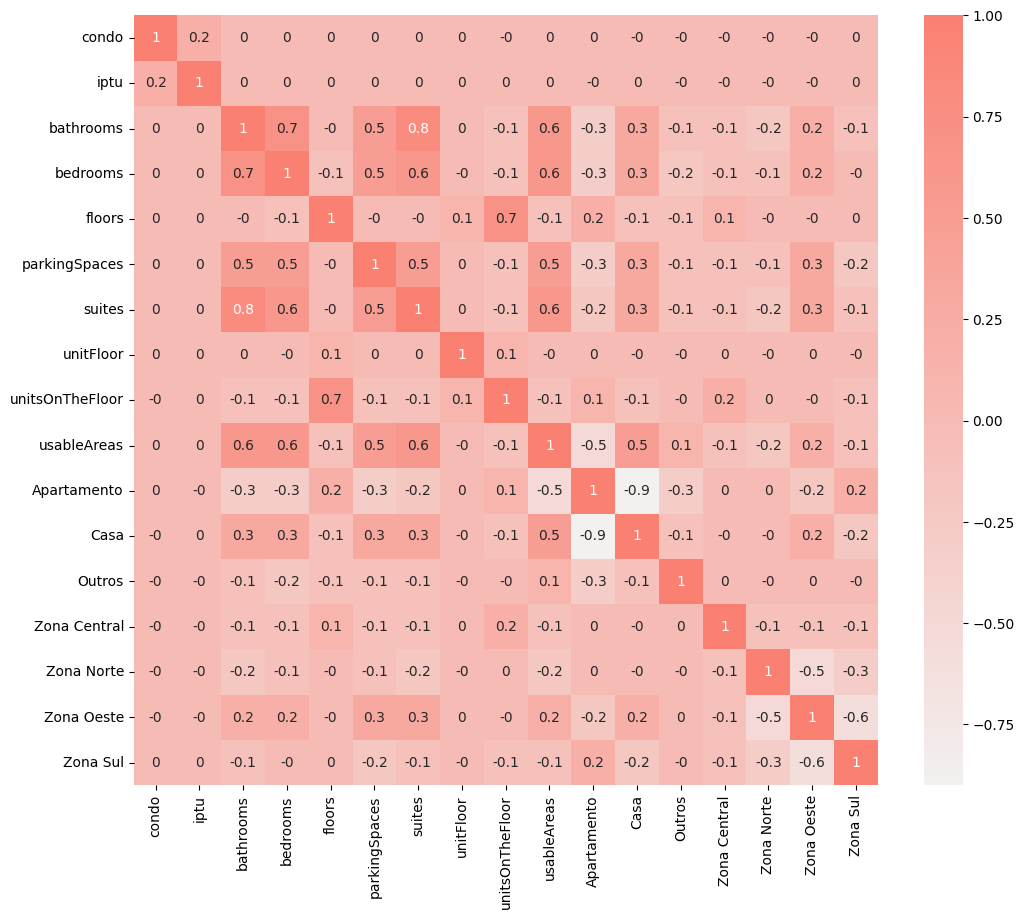

In [ ]:
plt.figure(figsize=(12,10))
paleta = sns.color_palette('light:salmon', as_cmap = True)
sns.heatmap(dataframe_correlacao.round(1), annot=True, cmap=paleta)

**Regressão Linear**

In [ ]:
from pyspark.ml.regression import LinearRegression

In [ ]:
# separando os dados entre treino e teste

treino, teste = dataset_rep.randomSplit([0.7,0.3])

In [ ]:
# criando o modelo regressor

lr = LinearRegression()

In [ ]:
# passando para o modelo, o ajuste dos dados

modelo_lr = lr.fit(treino)

In [ ]:
# com base nessas previsões eu vou gerar as metricas para avaliar o modelo

previsao_lr_treino = modelo_lr.transform(treino)

In [ ]:
previsao_lr_treino.show(truncate=False)

+------------------------------------------------------------------------------+--------+------------------+
|features                                                                      |label   |prediction        |
+------------------------------------------------------------------------------+--------+------------------+
|(17,[0,1,2,3,4,5,6,9,10,13],[400.0,100.0,2.0,1.0,32.0,1.0,1.0,32.0,1.0,1.0])  |329000.0|636077.251468814  |
|(17,[0,1,2,3,4,5,6,9,10,13],[1000.0,2000.0,1.0,3.0,15.0,1.0,1.0,75.0,1.0,1.0])|820000.0|906802.9057273443 |
|(17,[0,1,2,3,4,5,6,9,10,14],[1.0,1.0,2.0,2.0,7.0,1.0,1.0,68.0,1.0,1.0])       |577800.0|529393.2855882288 |
|(17,[0,1,2,3,4,5,6,9,10,14],[10.0,10.0,2.0,2.0,10.0,1.0,1.0,56.0,1.0,1.0])    |361377.0|470310.70110549737|
|(17,[0,1,2,3,4,5,6,9,10,14],[320.0,350.0,1.0,3.0,5.0,1.0,1.0,60.0,1.0,1.0])   |360000.0|478344.6452221596 |
|(17,[0,1,2,3,4,5,6,9,10,14],[500.0,170.0,1.0,2.0,3.0,1.0,1.0,120.0,1.0,1.0])  |580000.0|717852.7625061506 |
|(17,[0,1,2,3,4,5,6

**Extraindo métricas - regressão linear**

In [ ]:
resumo_treino = modelo_lr.summary

In [ ]:
resumo_treino.r2

0.666423107370658

In [ ]:
resumo_treino.rootMeanSquaredError

806602.1073379982

In [ ]:
resumo_teste = modelo_lr.evaluate(teste)

In [ ]:
resumo_teste.r2

0.6554028184302374

In [ ]:
resumo_teste.rootMeanSquaredError

810615.7543978458

In [ ]:
# Imprimindo resultado final do treino e teste, com o R² e o RMSE

print('Regressão Linear')
print('')
print('R² Treino: %f'% resumo_treino.r2)
print('RMSE Treino: %f'% resumo_treino.rootMeanSquaredError)
print('='*30)
print('R² Teste: %f'% resumo_teste.r2)
print('RMSE Teste: %f'% resumo_teste.rootMeanSquaredError)

Regressão Linear

R² Treino: 0.666423
RMSE Treino: 806602.107338
R² Teste: 0.655403
RMSE Teste: 810615.754398


**Árvore de Decisão**

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

In [ ]:
# o maxDepth=7 é a profundidade que minha arvore vai ter, ou seja, quantas decisões
# que ela via ter

dtr = DecisionTreeRegressor(maxDepth=7)

In [ ]:
modelo_dtr = dtr.fit(treino)

In [ ]:
previsao_dtr_treino = modelo_dtr.transform(treino)

In [ ]:
previsao_dtr_treino.show(truncate=False)

+------------------------------------------------------------------------------+--------+------------------+
|features                                                                      |label   |prediction        |
+------------------------------------------------------------------------------+--------+------------------+
|(17,[0,1,2,3,4,5,6,9,10,13],[400.0,100.0,2.0,1.0,32.0,1.0,1.0,32.0,1.0,1.0])  |329000.0|373121.4411846885 |
|(17,[0,1,2,3,4,5,6,9,10,13],[1000.0,2000.0,1.0,3.0,15.0,1.0,1.0,75.0,1.0,1.0])|820000.0|695440.409556314  |
|(17,[0,1,2,3,4,5,6,9,10,14],[1.0,1.0,2.0,2.0,7.0,1.0,1.0,68.0,1.0,1.0])       |577800.0|557162.3902961113 |
|(17,[0,1,2,3,4,5,6,9,10,14],[10.0,10.0,2.0,2.0,10.0,1.0,1.0,56.0,1.0,1.0])    |361377.0|373121.4411846885 |
|(17,[0,1,2,3,4,5,6,9,10,14],[320.0,350.0,1.0,3.0,5.0,1.0,1.0,60.0,1.0,1.0])   |360000.0|373121.4411846885 |
|(17,[0,1,2,3,4,5,6,9,10,14],[500.0,170.0,1.0,2.0,3.0,1.0,1.0,120.0,1.0,1.0])  |580000.0|696450.047311828  |
|(17,[0,1,2,3,4,5,6

In [ ]:
# Olhando o modelo, parece que os valores está muito parecidos com os preços
# originais, para verificar de fato se esse modelo está bom, vou extrair as metricas

**Extraindo Métricas - Árvore de Decisão**

In [ ]:
# diferente da regressão linear, dessa vez vou utilizar um objeto que vai ajudar
# a avaliar o modelo, esse objeto se chama, avaliador de regressão

from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
evaluator = RegressionEvaluator()

In [ ]:
print(evaluator.evaluate(previsao_dtr_treino,{evaluator.metricName:'r2'}))
print(evaluator.evaluate(previsao_dtr_treino,{evaluator.metricName:'rmse'}))

0.7918499202630818
637161.7020426595


In [ ]:
previsao_dtr_teste = modelo_dtr.transform(teste)

In [ ]:
print(evaluator.evaluate(previsao_dtr_teste,{evaluator.metricName:'r2'}))
print(evaluator.evaluate(previsao_dtr_teste,{evaluator.metricName:'rmse'}))

0.7707519426201253
661168.2827160703


In [ ]:
# imprimindo resultado final de treino e teste a Árvore de Decisão

print('Árvore de Decisão')
print('')
print('R² Treino: %f'% evaluator.evaluate(previsao_dtr_treino,{evaluator.metricName:'r2'}))
print('RMSE Treino: %f'% evaluator.evaluate(previsao_dtr_treino,{evaluator.metricName:'rmse'}))
print('='*30)
print('R² Teste: %f'%evaluator.evaluate(previsao_dtr_teste,{evaluator.metricName:'r2'}))
print('RMSE Teste: %f'%evaluator.evaluate(previsao_dtr_teste,{evaluator.metricName:'rmse'}))

Árvore de Decisão

R² Treino: 0.791850
RMSE Treino: 637161.702043
R² Teste: 0.770752
RMSE Teste: 661168.282716


Se formos comparar com a metricas de regressão linear que era de 65% o r2, esse da árvore é de 77%, que já é um bom ganho.

**Random Forest - Regressão**

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(maxDepth=7, numTrees=10)

In [ ]:
modelo_rfr = rfr.fit(treino)

In [ ]:
previsao_rfr_treino = modelo_rfr.transform(treino)

**Extraindo Métricas - Random Forest**

In [ ]:
print(evaluator.evaluate(previsao_rfr_treino,{evaluator.metricName:'r2'}))
print(evaluator.evaluate(previsao_rfr_treino,{evaluator.metricName:'rmse'}))

0.8027470526788684
620259.069749801


In [ ]:
previsao_rfr_teste = modelo_rfr.transform(teste)

In [ ]:
print(evaluator.evaluate(previsao_rfr_teste,{evaluator.metricName:'r2'}))
print(evaluator.evaluate(previsao_rfr_teste,{evaluator.metricName:'rmse'}))

0.7943181899685657
626263.5309355758


In [ ]:
print('Random Forest')
print('')
print('R² Treino: %f'% evaluator.evaluate(previsao_rfr_treino,{evaluator.metricName:'r2'}))
print('RMSE Treino: %f'% evaluator.evaluate(previsao_rfr_treino,{evaluator.metricName:'rmse'}))
print('='*30)
print('R² Teste: %f'%evaluator.evaluate(previsao_rfr_teste,{evaluator.metricName:'r2'}))
print('RMSE Teste: %f'%evaluator.evaluate(previsao_rfr_teste,{evaluator.metricName:'rmse'}))

Random Forest

R² Treino: 0.802747
RMSE Treino: 620259.069750
R² Teste: 0.794318
RMSE Teste: 626263.530936


**Otimizando Modelos**

**Otimizando Modelo de Árvore de Decisão**

In [ ]:
# O CossValidator é o objeto responsavel por fazer separar todas a separação entre
# treino e teste, e vou utilizar também o contrutor de Grid Parametros, que vai
# permitir que eu trabalhe com varios parametros diferentes.

from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
# criando o objeto regressor

dtr = DecisionTreeRegressor()

In [ ]:
# passando os parametros o qual quero que seja testado para ver qual vai se dar melhor,
# maxDepth = profundidade da arvore, maxBins = quantidade de vezes que a minha arvore
# de decisão vai tentar montar aqueles nós, com diferentes funções, o quão refinado
# vai ter a tentativa para montar esses nós.

grid = ParamGridBuilder()\
      .addGrid(dtr.maxDepth,[2,5,10])\
      .addGrid(dtr.maxBins,[10,32,45])\
      .build()

In [ ]:
# gerar um avaliador

evaluator = RegressionEvaluator()

In [ ]:
# criando um objeto crossvalidator

# estimator = tipo do modelo, estimatorParamMaps = grid que acabou de criar, evaluator =
# o próprio evaluator, numFolds = tentativas de quebrar o modelo em diferentes treino
# e testes

dtr_cv = CrossValidator(
    estimator=dtr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3
)

In [ ]:
# ajustando os dados

modelo_dtr_cv = dtr_cv.fit(treino)

In [ ]:
# fazendo a previsão do modelo

previsao_dtr_cv = modelo_dtr_cv.transform(teste)

In [ ]:
# fazendo a comparação entre o modelo sem otimização e o modelo otimizado

print('Árvore de Decisão Sem Otimização')
print('')
print('R² Teste: %f'%evaluator.evaluate(previsao_dtr_teste,{evaluator.metricName:'r2'}))
print('RMSE Teste: %f'%evaluator.evaluate(previsao_dtr_teste,{evaluator.metricName:'rmse'}))
print('='*30)
print('Árvore de Decisão Com Otimização')
print('')
print('R² Teste: %f'%evaluator.evaluate(previsao_dtr_cv,{evaluator.metricName:'r2'}))
print('RMSE Teste: %f'%evaluator.evaluate(previsao_dtr_cv,{evaluator.metricName:'rmse'}))

Árvore de Decisão Sem Otimização

R² Teste: 0.770752
RMSE Teste: 661168.282716
Árvore de Decisão Com Otimização

R² Teste: 0.786124
RMSE Teste: 638616.985248


**Otimizando Modelo de Random Forest**

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
rfr = RandomForestRegressor()

In [ ]:
grid = ParamGridBuilder()\
      .addGrid(rfr.numTrees,[10,20,30])\
      .addGrid(rfr.maxDepth,[5,10])\
      .addGrid(rfr.maxBins,[10,32,45])\
      .build()

In [ ]:
evaluator = RegressionEvaluator()

In [ ]:
rfr_cv = CrossValidator(
    estimator = rfr,
    estimatorParamMaps = grid,
    evaluator = evaluator,
    numFolds= 3
)

In [ ]:
modelo_rfr_cv = rfr_cv.fit(treino)

In [ ]:
previsao_rfr_cv = modelo_rfr_cv.transform(teste)

In [ ]:
# fazendo a comparação entre o Random Forest sem otimização e com otimização

print('Random Forest Sem Otimização')
print('')
print('R² Teste: %f'%evaluator.evaluate(previsao_rfr_teste,{evaluator.metricName:'r2'}))
print('RMSE Teste: %f'%evaluator.evaluate(previsao_rfr_teste,{evaluator.metricName:'rmse'}))
print('='*30)
print('Random Forest Com Otimização')
print('')
print('R² Teste: %f'%evaluator.evaluate(previsao_rfr_cv,{evaluator.metricName:'r2'}))
print('RMSE Teste: %f'%evaluator.evaluate(previsao_rfr_cv,{evaluator.metricName:'rmse'}))

Random Forest Sem Otimização

R² Teste: 0.794318
RMSE Teste: 626263.530936
Random Forest Com Otimização

R² Teste: 0.832793
RMSE Teste: 564659.667738


**Prevendo Resultado com o melhor modelo**

Vou criar um novo imóvel do jeito que eu quiser e utilizando o melhor modelo que foi o de Random Forest Otimizado, prever qual o valor eu tenho que ter para comprar esse imóvel

In [ ]:
X

['condo',
 'iptu',
 'bathrooms',
 'bedrooms',
 'floors',
 'parkingSpaces',
 'suites',
 'unitFloor',
 'unitsOnTheFloor',
 'usableAreas',
 'Apartamento',
 'Casa',
 'Outros',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul']

In [ ]:
# criando o novo imovel

novo_imovel = [{
    'condo':200,
    'iptu':0,
    'bathrooms':2,
    'bedrooms':2,
    'floors':1,
    'parkingSpaces':1,
    'suites':1,
    'unitFloor':0,
    'unitsOnTheFloor':0,
    'usableAreas':1,
    'Apartamento':1,
    'Casa':0,
    'Outros':0,
    'Zona Central':0,
    'Zona Norte':0,
    'Zona Oeste':0,
    'Zona Sul':1,
    'label':0
}]

In [ ]:
# criando um dataframe do spark com esse novo imovel

meu_imovel = spark.createDataFrame(novo_imovel)

In [ ]:
# utilizando o assembler para receber quais colunas desejo trabalhar

assembler = VectorAssembler(inputCols=X, outputCol='features')

In [ ]:
# vetorizando o novo imóvel

meu_lar_vetorizado = assembler.transform(meu_imovel).select('features','label')

In [ ]:
meu_lar_vetorizado.show(truncate=False)

+------------------------------------------------------------------+-----+
|features                                                          |label|
+------------------------------------------------------------------+-----+
|(17,[0,2,3,4,5,6,9,10,16],[200.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0])|0    |
+------------------------------------------------------------------+-----+



In [ ]:
# prevendo o valor com o modelo

modelo_rfr_cv.transform(meu_lar_vetorizado).show()

+--------------------+-----+----------------+
|            features|label|      prediction|
+--------------------+-----+----------------+
|(17,[0,2,3,4,5,6,...|    0|811770.665713355|
+--------------------+-----+----------------+

